<a href="https://colab.research.google.com/github/karthick-2/eqew/blob/main/car_damage_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building Damage Classifier

### Approach 

Since, i have not given a csv or json file with labels so i have to generate them. Now all the given images have different sizes i have to augment then into a specific size. As for model , i use diffenent model and choose the one with better accuracy. I choose Resnext50 model by changing its classifier.
I use hit and trial method for choosing number of epochs. And for validation data, random indexes were generated. After training , i saved the model weights in a  pickle file.

### Augmentation Policy 

For augmentation i used,

`->` Resize - As images are of different size, i fixed their size to (128,128) pixels.

`->` I have used random horizontal flip and random vertical flip to flip images

`->` And finally , i converted images to tensors.

### Evaluation Metrics

I used accuracy as my evaluation metrics, since it describes how good the model is doing on validation and test data much better and it is easy to use and easy to understand.

# New Section

# New Section

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
img = cv2.imread("/home/k/Downloads/data1a/training/00-damage/0001.JPEG")
img.shape

AttributeError: ignored

In [ ]:
!pip install timm

     |████████████████████████████████| 376 kB 3.1 MB/s            


In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import random
import timm
import torchvision
from torchvision import transforms
from tqdm import tqdm
import os
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2
import albumentations
import pickle


from sklearn.metrics import accuracy_score


warnings.filterwarnings("ignore")

In [ ]:
seed = 1000
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

seed_everything(seed)

In [ ]:
train_val_path = "/home/k/Downloads/data1a/training"
transform=transforms.Compose([
                                  transforms.Resize([128,128]),
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  transforms.RandomVerticalFlip(p=0.5),
                                  transforms.ToTensor()
])

In [ ]:
dataset=ImageFolder(train_val_path,transform=transform)

In [ ]:
img0,label0 = dataset[6]
print(img0.shape,label0)
img10,label10 = dataset[10]
print(img10.shape,label10)
print(dataset.classes)

torch.Size([3, 128, 128]) 0
torch.Size([3, 128, 128]) 0
['00-damage', '01-whole']


label: 0


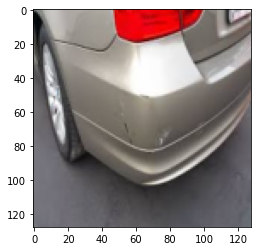

In [ ]:
def show_img_with_label(img,label):
    print("label:" ,label)
    plt.imshow(img.permute(1,2,0))
    
show_img_with_label(img0,label0)

In [ ]:
print(dataset.classes[0])
print(dataset.classes[1])
print(len(dataset))

00-damage
01-whole
1840


In [ ]:
val_num= int(len(dataset)*0.3)
index = np.random.permutation(len(dataset))
val_idx = index[:val_num]
train_idx = index[val_num:]
print(val_idx[:5])

[  23 1360  775  669 1209]


In [ ]:
batch_size = 16

train_sampler = SubsetRandomSampler(train_idx)
train_df = DataLoader(dataset,batch_size = batch_size,sampler = train_sampler)

val_sampler = SubsetRandomSampler(val_idx)
val_df = DataLoader(dataset,batch_size=batch_size,sampler = val_sampler)

In [ ]:
class Model(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, 2)

    def forward(self, x):
        x = self.model(x)
        return x
    
model = Model()

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model.to(device)

Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): ReLU(inplace=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act2): ReLU(inplace=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [ ]:
loss_type = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [ ]:
loss_val = []
for epoch in range(1):
    
    print("epoch: " , epoch+1)
    running_loss = 0
    for(i,data) in enumerate(train_df):
        img,label = data
        img,label = img.to(device),label.to(device)
        
        optimizer.zero_grad()
        
        output_label = model(img)
        
        loss = loss_type(output_label,label)
        
        loss.backward()
        
        optimizer.step()
        running_loss = running_loss + loss.item()*img.size(0)
    
    loss_val.append(running_loss/len(train_df))
    
    print(running_loss)

plt.plot(loss_val,label="loss")
plt.legend()

epoch:  1


In [ ]:
preds = []
labels = []

with torch.no_grad():
    for data in val_df:
        img,label = data
        img,label = img.to(device),label.to(device)
        
        output = model(img)
        _,predicted = torch.max(output,dim=1)
        
        
        preds.extend(predicted.cpu().detach().numpy())
        labels.extend(label.cpu().detach().numpy())
    
print("Accuracy: {}".format(accuracy_score(labels,preds)) )

In [ ]:
model_path = "Resnext_model.pkl"
with open(model_path,'wb') as f:
    pickle.dump(model,f)

In [ ]:
with open(model_path,'rb') as f:
    model = pickle.load(f)

In [ ]:
test_dir = "../input/car-damage-detection/data1a/validation"

transform=transforms.Compose([
                              transforms.Resize([128,128]),
                              transforms.RandomHorizontalFlip(p=0.5),
                              transforms.RandomVerticalFlip(p=0.5),
                              transforms.ToTensor()
])
test_data = ImageFolder(test_dir,transform = transform)

In [ ]:
batch_size = 32

test_df = DataLoader(test_data,batch_size)

In [ ]:
preds = []
labels = []

with torch.no_grad():
    for data in test_df:
        img,label = data
        img,label = img.to(device),label.to(device)
        output = model(img)
        _,predicted = torch.max(output,dim=1)
        
        preds.extend(predicted.cpu().detach().numpy())
        labels.extend(label.cpu().detach().numpy())
        
print(f"Accuracy for test data : {accuracy_score(preds,labels)}")